In this document we will test the generation capabilities of our NeSy-MM model, and the baselines. First, let us import the required packages.

In [1]:
import os
import tensorflow as tf
import einops as E
import matplotlib.pyplot as plt

2024-08-15 09:58:08.854088: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Select the grid size and the model to use. The grid size can be 5 or 10. The model can be "nesymm", "deephmm", or "transformer".

In [2]:
MODEL = "nesymm"  # options: nesymm, deephmm, transformer

Import and instantiate the chosen model.

In [3]:
downsample = 1
grid_size = 5
image_shape = (
    (grid_size + 2) * 16 // downsample,
    (grid_size + 2) * 16 // downsample,
    3,
)
latent_dim = 2
horizon = 10
dropout = 0.4
seed = 42
n_samples = 1
    
if MODEL == "nesymm":
    from nesy_mm.experiments.minihack_vae.model import MinihackVAEModel

    model = MinihackVAEModel(
        grid_size,
        n_samples,
        latent_dim,
        image_shape,
        dropout,
        horizon,
        downsample=downsample,
    )
    
    # dummy input to build the model
    model([tf.ones((1, horizon, *image_shape), dtype=tf.float32), tf.ones((1, horizon), dtype=tf.int32)])
elif MODEL == "deephmm":
    from nesy_mm.experiments.minihack_vae.baselines.deep_hmm.model import MinihackVAEModelHMM
    
    model = MinihackVAEModelHMM(
        grid_size,
        n_samples,
        latent_dim,
        image_shape,
        dropout,
        horizon,
        downsample=downsample,
    )
    
    # dummy input to build the model
    model([tf.ones((1, horizon, *image_shape), dtype=tf.float32), tf.ones((1, horizon), dtype=tf.int32)])
elif MODEL == "transformer":
    from nesy_mm.experiments.minihack_vae.baselines.transformer.model import Bumblebee

    model = Bumblebee(grid_size, horizon, image_shape, downsample)
    
    # dummy input to build the model
    model(tf.ones((1, horizon, *image_shape), dtype=tf.float32), tf.ones((1, horizon, 4), dtype=tf.int32))
else:
    raise ValueError("Invalid model name")

Load the weights of the trained model.

In [4]:
model_dir = f"released_models/minihack-vae/{MODEL}/"

model_weights_name = (
    f"minihack-vae_{grid_size}x{grid_size}_horizon{horizon}_final_seed{seed}.h5"
)

model.load_weights(os.path.join(model_dir, model_weights_name))

Select the actions for the sequence you want to generate, and, optionally, a starting location. Notice that the starting location can be given only to the NeSy-MM or the Deep-MM, because the transformer does not have an explicit concept of location we can use. This is part of the reason why NeSy-MMs are more interpretable.

In [5]:
actions_list = [1, 2, 3, 0, 3, 0, 1, 2]  # 0: up, 1: right, 2: down, 3: left
starting_location = None  # [row,col] or None for random location

actions = tf.constant(actions_list, dtype=tf.int32)
if MODEL == "transformer":
    actions = tf.one_hot(actions, depth=4)
    actions = E.rearrange(actions, "t o -> 1 t o")

loc = None
if starting_location is not None:
    loc = tf.constant(starting_location, dtype=tf.int32)

Generate and plot the trajectories!

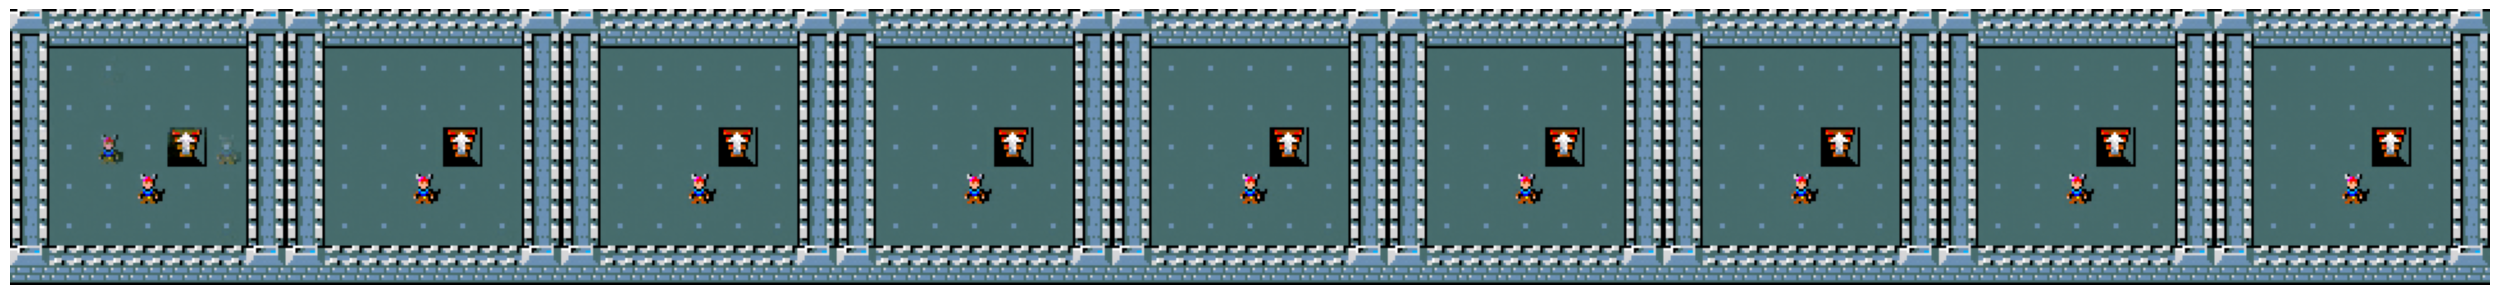

In [6]:
if MODEL == "transformer":
    generations = model.generate(actions)
else:
    generations = model.generate(actions, 1, starting_loc=loc)
    generations = E.rearrange(generations, "1 t s h w c -> s t h w c")
generation = generations[0]

image = [img for img in generation]
image = tf.concat(image, axis=1)

# Desired size in pixels
height_px = 400
width_px = height_px * len(actions_list)

# DPI (dots per inch)
dpi = 100

# Convert pixels to inches
width_in = width_px / dpi
height_in = height_px / dpi

# Create a new figure with the specified size in inches
plt.figure(figsize=(width_in, height_in), dpi=dpi)
plt.imshow(image)
plt.axis("off")
plt.show()

NeSy-MMs are test-time interveanable, meaning that we can add additional logical constraints at test time and generate sequences of images according to these constraints. In the following example, we will generate a sequence of images where the agent must avoid the last two columns of the grid. We can see this an additional safety constraint due to a different environment at deployment time, for example.

In [7]:
if MODEL == "nesymm":
    generations = model.generate_with_constraint(actions)
    generations = E.rearrange(generations, "1 t s h w c -> s t h w c")
    generation = generations[0]
    
    image = [img for img in generation]
    image = tf.concat(image, axis=1)
    
    # Desired size in pixels
    height_px = 400
    width_px = height_px * len(actions_list)
    
    # DPI (dots per inch)
    dpi = 100
    
    # Convert pixels to inches
    width_in = width_px / dpi
    height_in = height_px / dpi
    
    # Create a new figure with the specified size in inches
    plt.figure(figsize=(width_in, height_in), dpi=dpi)
    plt.imshow(image)
    plt.axis("off")
    plt.show()
else:
    print("This feature is only available for NeSy-MMs")

This feature is only available for NeSy-MMs
